In [51]:
# 필요한 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Embedding, Dense, SimpleRNN, LSTM, Bidirectional, Flatten,Dropout
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2, l1_l2

In [52]:
# 1) 데이터 로드 및 전처리 (자세한 주석 포함)
# --------------------------------------------------
# movie_reviews.fileids(): 각 리뷰 파일의 id 목록(각 파일이 하나의 문서)
ids = movie_reviews.fileids()
# movie_reviews.raw(id): 해당 파일의 전체 텍스트(문서 원문)를 반환
reviews = [movie_reviews.raw(i) for i in ids]  # 문서 문자열 리스트
# movie_reviews.categories(id): 해당 파일의 라벨 리스트(e.g., ['pos'] 또는 ['neg'])
categories = [movie_reviews.categories(i)[0] for i in ids]  # 'pos'/'neg'

# ----- 토크나이저 설정 -----
# max_word: 어휘 크기 제한. 상위 max_word-1개의 빈도 단어만 인덱싱에 사용됩니다.
# oov_token: 사전에 없는 단어를 나타내는 토큰(Out-Of-Vocabulary)으로, 인코딩 시 해당 토큰으로 대체
max_word = 10000
tokenizer = Tokenizer(num_words=max_word, oov_token='UNK')
# fit_on_texts: 토크나이저가 문서 전체를 훑어 단어 빈도 기반 인덱스를 생성합니다.
tokenizer.fit_on_texts(reviews)

# 텍스트를 정수 시퀀스로 변환(단어 -> 인덱스)
# 예: ['this','movie'] -> [12, 54] (각 단어는 tokenizer가 학습한 인덱스로 매핑)
x = tokenizer.texts_to_sequences(reviews)

# 패딩(pad_sequences): 모델 입력은 고정 길이를 요구하므로 시퀀스 길이를 통일합니다.
# maxlen: 허용되는 최대 길이(너무 긴 시퀀스는 truncating으로 잘라냄),
# truncating='pre'이면 앞쪽을 자르고 'post'면 뒤쪽을 자름(데이터에 따라 선택)
maxlen = 500
x = pad_sequences(x, maxlen=maxlen, truncating='pre')

# 레이블(문자열)을 수치로 변환하여 모델 학습에 사용합니다. pos->1, neg->0
label_dict = {'pos': 1, 'neg': 0}
y = np.array([label_dict[c] for c in categories])

# 학습/테스트 분할: stratify=y로 클래스 비율을 유지, random_state로 재현성 확보
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42, test_size=0.2)


In [53]:
# 2 .세가지 모델 구축 , 학습
# 시드고정(재현성)
np.random.seed(42)
tf.random.set_seed(42)
# 모델 성능
results = {}
# ------ model 1 baseline(Flatten + Dense)
model1 = Sequential([
    Embedding(max_word,32,input_length = maxlen),
    Flatten(),   
    Dropout(0.5) ,
    Dense(1,activation='sigmoid')
])
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'])
history1 = model1.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)
score1 = model1.evaluate(x_test,y_test)
results['baseline'] = score1[1]
print(f'model1 정확도:{score1[1]:.4f}')

# ------ model 2 (SimpleRnn)
model2 = Sequential([
    Embedding(max_word,32,input_length = maxlen),
    SimpleRNN(32),
    Dense(32,activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'])
history2 = model2.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)
score1 = model2.evaluate(x_test,y_test)
results['Simple_RNN'] = score1[1]
print(f'model2 정확도:{score1[1]:.4f}')

# ------ model 3 (Bidirectional LSTM)
model3 = Sequential([
    Embedding(max_word,64,input_length = maxlen),
    Bidirectional(LSTM(64)),    
    Dense(64,activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'])
history3 = model3.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)
score1 = model3.evaluate(x_test,y_test)
results['Bidirectional_LSTM'] = score1[1]
print(f'model3 정확도:{score1[1]:.4f}')

Epoch 1/10


c:\Users\khh11\miniconda3\envs\pyt_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.5117 - loss: 0.6931 - val_acc: 0.5219 - val_loss: 0.6915
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.5117 - loss: 0.6931 - val_acc: 0.5219 - val_loss: 0.6915
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9047 - loss: 0.6216 - val_acc: 0.5594 - val_loss: 0.6881
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9047 - loss: 0.6216 - val_acc: 0.5594 - val_loss: 0.6881
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9609 - loss: 0.5337 - val_acc: 0.5719 - val_loss: 0.6812
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9609 - loss: 0.5337 - val_acc: 0.5719 - val_loss: 0.6812
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9859 - loss: 0.4144 - val_acc: 0.5656 - val_loss: 0.6721
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9859 - loss: 0.4144 - val_acc: 0.5656 - val_loss: 0.6721
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9945 - loss: 0.2892 - va

In [54]:
history3.history

{'acc': [0.520312488079071,
  0.5562499761581421,
  0.739062488079071,
  0.824999988079071,
  0.93359375,
  0.9781249761581421,
  0.983593761920929,
  0.9781249761581421,
  0.9765625,
  0.991406261920929],
 'loss': [1.30509352684021,
  0.9736006855964661,
  0.7516138553619385,
  0.504626452922821,
  0.24316909909248352,
  0.1288887858390808,
  0.10011987388134003,
  0.10638991743326187,
  0.10304906219244003,
  0.07234574854373932],
 'val_acc': [0.550000011920929,
  0.578125,
  0.675000011920929,
  0.762499988079071,
  0.668749988079071,
  0.731249988079071,
  0.6625000238418579,
  0.71875,
  0.765625,
  0.746874988079071],
 'val_loss': [1.1022462844848633,
  0.8639521598815918,
  0.701519250869751,
  0.6260960102081299,
  0.8035538792610168,
  0.7678138613700867,
  0.9718022346496582,
  0.9733083844184875,
  0.6739236116409302,
  0.7494121789932251]}

 Bidirectional_LSTM : 0.7400
 Simple_RNN : 0.6550
 baseline : 0.6225


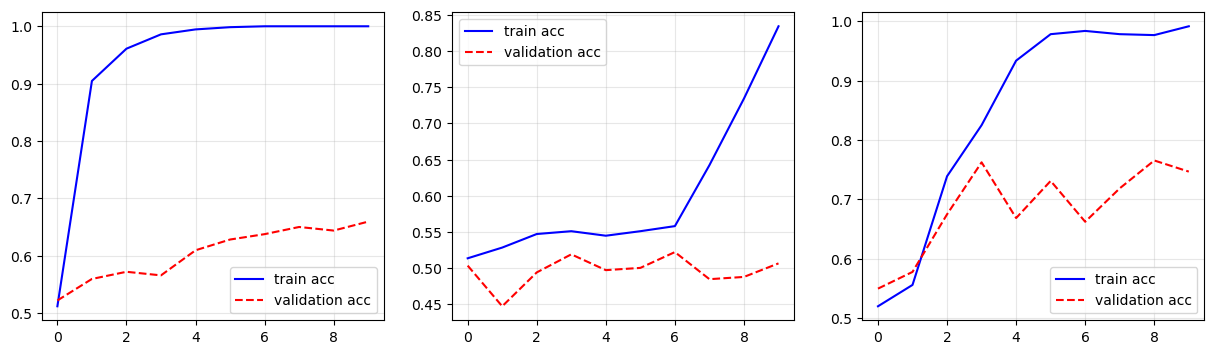

In [58]:
# 3 .성능 비교 및 시각화
for modelname, acc in  sorted(results.items(), key =lambda x : x[1],reverse=True):
    print(f' {modelname} : {acc:.4f}')

fig,ax =  plt.subplots(1,3,figsize=(15,4))
# baseline
ax[0].plot(history1.history['acc'], 'b-', label='train acc')
ax[0].plot(history1.history['val_acc'], 'r--', label='validation acc')
ax[0].legend()
ax[0].grid(True,alpha=0.3)
# SmpleRnn
ax[1].plot(history2.history['acc'], 'b-', label='train acc')
ax[1].plot(history2.history['val_acc'], 'r--', label='validation acc')
ax[1].legend()
ax[1].grid(True,alpha=0.3)
# Bidirectional_LSTM
ax[2].plot(history3.history['acc'], 'b-', label='train acc')
ax[2].plot(history3.history['val_acc'], 'r--', label='validation acc')
ax[2].legend()
ax[2].grid(True,alpha=0.3)

In [ ]:
# 단어를 고차원 벡터로 표현하는 기술
# Glove(Global Vectors for W)

In [57]:
# 5 .학습결과 해석